In [ ]:
import sys; sys.argv=['']; del sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_data, process_graph_data
from utils import package_mxl, adj_rw_norm
from utils import sparse_mx_to_torch_sparse_tensor
from utils import ResultRecorder

from model import GCN, GCNBias, SGC, ResGCN, GCNII, APPNP, MLP
from load_semigcn_data import load_data_gcn
from data_loader import DataLoader

import numpy as np
import copy 
import time
from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import trange
from scipy.sparse.csgraph import connected_components
import pickle
import os
import math

In [3]:
def ContextualSBM(n, d, Lambda, p, mu):
    # n = 800 #number of nodes
    # d = 5 # average degree
    # Lambda = 1 # parameters
    # p = 1000 # feature dim
    # mu = 1 # mean of Gaussian
    gamma = n/p

    c_in = d + np.sqrt(d)*Lambda
    c_out = d - np.sqrt(d)*Lambda
    y = np.ones(n)
    y[int(n/2)+1:] = -1
    y = np.asarray(y, dtype=int)

    # creating edge_index
    edge_index = [[], []]
    for i in range(n-1):
        for j in range(i+1, n):
            if y[i]*y[j] > 0:
                Flip = np.random.binomial(1, c_in/n)
            else:
                Flip = np.random.binomial(1, c_out/n)
            if Flip > 0.5:
                edge_index[0].append(i)
                edge_index[1].append(j)
                edge_index[0].append(j)
                edge_index[1].append(i)
    edge_index = np.array(edge_index)
    
    # creating node features
    x = np.zeros([n, p])
    u = np.random.normal(0, 1/np.sqrt(p), [1, p])
    for i in range(n):
        Z = np.random.normal(0, 1, [1, p])
        x[i] = np.sqrt(mu/n)*y[i]*u + Z/np.sqrt(p)
    return x, (y + 1) // 2, edge_index

In [4]:
def parameterized_Lambda_and_mu(phi, p, n, epsilon=0.1):
    from math import pi
    gamma = n / p
    assert (phi >= 0) and (phi <= 1)
    Lambda = np.sqrt(1 + epsilon) * np.sin(phi * pi / 2)
    mu = np.sqrt(gamma * (1 + epsilon)) * np.cos(phi * pi / 2)
    return Lambda, mu

In [5]:
n = 800
d = 5
p = 1000
epsilon = 3.25
phi = 0.5
Lambda, mu = parameterized_Lambda_and_mu(phi, p, n, epsilon)
print(Lambda, mu)

1.457737973711325 1.30384048104053


In [6]:
import scipy.sparse as sp
def sym_normalize(adj):
    adj.setdiag(1)
    rowsum = np.array(adj.sum(1)) + 1e-20
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt, 0)
    adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)
    return adj
device = torch.device("cuda:0")

In [7]:
num_classes = 1
criterion = nn.BCEWithLogitsLoss()
n_feat = p

def generate_data():
    feat_data, labels, edge_index = ContextualSBM(n, d, Lambda, p, mu)
    labels = np.expand_dims(labels, axis=1)

    from scipy.sparse import csr_matrix
    row = np.array(edge_index[0])
    col = np.array(edge_index[1])
    data = np.array(np.ones_like(edge_index[0]))

    adj_mat = csr_matrix((data, (row, col)), shape=(n, n))
    adj_mat.setdiag(1)

    all_nodes = np.random.permutation(n)
    train_nodes = all_nodes[:600]
    valid_nodes = all_nodes[600:700]
    test_nodes = all_nodes[700:]

    feat_data_th = torch.FloatTensor(feat_data).to(device)
    labels_th = torch.FloatTensor(labels).to(device)

    lap_mat = sym_normalize(adj_mat)
    lap_tensor = sparse_mx_to_torch_sparse_tensor(lap_mat)
    lap_tensor = torch.sparse.FloatTensor(lap_tensor[0],
                                          lap_tensor[1], 
                                          lap_tensor[2]).to(device)
    return feat_data_th, labels_th, lap_tensor, train_nodes, valid_nodes, test_nodes

In [8]:
class SGC(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion):
        super(SGC, self).__init__()
        from layers import SGCLayer
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(SGCLayer())
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion

    def forward(self, x, adj):
        x = self.linear_in(x)
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj)
        x = self.linear_out(x)
        return x
    
    
class GCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion):
        from layers import GraphConv
        super(GCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        self.gcs.append(GraphConv(n_feat,  n_hid))
        for _ in range(n_layers-1):
            self.gcs.append(GraphConv(n_hid,  n_hid))
        self.linear = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion

    def forward(self, x, adj):
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj)
            x = self.relu(x)
        x = self.linear(x)
        return x
    
class ResGCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion):
        from layers import GraphConv
        super(ResGCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        self.gcs.append(GraphConv(n_feat,  n_hid))
        for _ in range(n_layers-1):
            self.gcs.append(GraphConv(n_hid,  n_hid))
        self.linear = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion

    def forward(self, x, adj):
        for ell in range(len(self.gcs)):
            if ell > 0:
                x_res = x.clone()
                x = self.gcs[ell](x, adj)
                x = self.relu(x) + x_res
            else:
                x = self.gcs[ell](x, adj)
                x = self.relu(x)
        x = self.linear(x)
        return x
    
class GCNII(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion):
        from layers import GCNIILayer
        super(GCNII, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(GCNIILayer(n_hid,  n_hid))
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion

    def get_alpha_beta(self, ell):
        alpha = 0.9
        beta = math.log(0.5/(ell+1)+1)
        return alpha, beta
    
    def forward(self, x, adj):
        x = self.linear_in(x)
        x_0 = x.clone()
        for ell in range(len(self.gcs)):
            alpha, beta = self.get_alpha_beta(ell)
            x = self.gcs[ell](x, adj, x_0, alpha, beta)
            x = self.relu(x)
        x = self.linear_out(x)
        return x
    
class APPNP(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion):
        from layers import APPNPLayer
        super(APPNP, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(APPNPLayer())
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion

    def forward(self, x, adj):
        x = self.linear_in(x)
        x_0 = x.clone()
        for ell in range(len(self.gcs)):
            alpha = 0.8
            x = self.gcs[ell](x, adj, x_0, alpha)
        x = self.linear_out(x)
        return x
    
class DGCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, criterion):
        from layers import DecoupleConv
        super(DGCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        self.softmax = nn.Softmax(dim=0)
        self.sigmoid = nn.Sigmoid()
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(DecoupleConv(n_hid,  n_hid))
            
        alpha = 0.1
        TEMP=alpha*(1-alpha)**np.arange(self.n_layers+1)
        TEMP[-1] = (1-alpha)**self.n_layers
        TEMP = np.log(TEMP)
        self.layer_weight = torch.nn.Parameter(torch.tensor(TEMP))
        self.identity_map_weight = torch.nn.Parameter(torch.zeros(self.n_layers))
        
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.criterion = criterion
    
    def forward(self, x, adj):
        x = self.linear_in(x)
        identity_map_weight = self.sigmoid(self.identity_map_weight)
        
        output_hiddens = []
        for ell in range(len(self.gcs)):
            x, x_w = self.gcs[ell](x, adj, identity_map_weight[ell])
            x_w = self.relu(x_w)
            output_hiddens.append(x_w)
            
        layer_weight = self.softmax(self.layer_weight)  
        for i in range(len(output_hiddens)):
            output_hiddens[i] = output_hiddens[i] * layer_weight[i]
            
        x = sum(output_hiddens)
        x = self.linear_out(x)
        return x

In [9]:
algorithm_result = dict()
algorithm_result['GCN'] = []
algorithm_result['ResGCN'] = []
algorithm_result['GCNII'] = []
algorithm_result['APPNP'] = []
algorithm_result['DGCN'] = []

In [10]:
n_hid = 64
n_layers = 4
MAX_EPOCH=200

for repeat in range(10):
    feat_data_th, labels_th, lap_tensor, train_nodes, valid_nodes, test_nodes = generate_data()
    
    model = APPNP(n_feat=n_feat, 
                n_hid=n_hid, 
                n_classes=num_classes, 
                n_layers=n_layers, 
                criterion=criterion).to(device)
    optimizer = optim.Adam(model.parameters())

    epoch_results = []
    for _ in range(MAX_EPOCH):
        pred = model(feat_data_th, lap_tensor)
        loss = model.criterion(pred[train_nodes], labels_th[train_nodes])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        valid_loss = model.criterion(pred[valid_nodes], labels_th[valid_nodes]).item()

        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        train_acc = f1_score(pred[train_nodes].detach().cpu(), 
                             labels_th[train_nodes].detach().cpu(), average="micro")
        valid_acc = f1_score(pred[valid_nodes].detach().cpu(), 
                             labels_th[valid_nodes].detach().cpu(), average="micro")
        test_acc = f1_score(pred[test_nodes].detach().cpu(), 
                             labels_th[test_nodes].detach().cpu(), average="micro")

        result = [train_loss, valid_loss, train_acc, valid_acc, test_acc]
        epoch_results.append(result)

    epoch_results = np.array(epoch_results)
    algorithm_result['APPNP'].append(epoch_results)

/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: Spars

In [11]:
for repeat in range(10):
    feat_data_th, labels_th, lap_tensor, train_nodes, valid_nodes, test_nodes = generate_data()
    
    model = DGCN(n_feat=n_feat, 
                n_hid=n_hid, 
                n_classes=num_classes, 
                n_layers=n_layers, 
                criterion=criterion).to(device)
    optimizer = optim.Adam(model.parameters())

    epoch_results = []
    for _ in range(MAX_EPOCH):
        pred = model(feat_data_th, lap_tensor)
        loss = model.criterion(pred[train_nodes], labels_th[train_nodes])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        valid_loss = model.criterion(pred[valid_nodes], labels_th[valid_nodes]).item()

        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        train_acc = f1_score(pred[train_nodes].detach().cpu(), 
                             labels_th[train_nodes].detach().cpu(), average="micro")
        valid_acc = f1_score(pred[valid_nodes].detach().cpu(), 
                             labels_th[valid_nodes].detach().cpu(), average="micro")
        test_acc = f1_score(pred[test_nodes].detach().cpu(), 
                             labels_th[test_nodes].detach().cpu(), average="micro")

        result = [train_loss, valid_loss, train_acc, valid_acc, test_acc]
        epoch_results.append(result)

    epoch_results = np.array(epoch_results)
    algorithm_result['DGCN'].append(epoch_results)

/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: Spars

In [12]:


for repeat in range(10):
    feat_data_th, labels_th, lap_tensor, train_nodes, valid_nodes, test_nodes = generate_data()
    
    model = ResGCN(n_feat=n_feat, 
                n_hid=n_hid, 
                n_classes=num_classes, 
                n_layers=n_layers, 
                criterion=criterion).to(device)
    optimizer = optim.Adam(model.parameters())

    epoch_results = []
    for _ in range(MAX_EPOCH):
        pred = model(feat_data_th, lap_tensor)
        loss = model.criterion(pred[train_nodes], labels_th[train_nodes])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        valid_loss = model.criterion(pred[valid_nodes], labels_th[valid_nodes]).item()

        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        train_acc = f1_score(pred[train_nodes].detach().cpu(), 
                             labels_th[train_nodes].detach().cpu(), average="micro")
        valid_acc = f1_score(pred[valid_nodes].detach().cpu(), 
                             labels_th[valid_nodes].detach().cpu(), average="micro")
        test_acc = f1_score(pred[test_nodes].detach().cpu(), 
                             labels_th[test_nodes].detach().cpu(), average="micro")

        result = [train_loss, valid_loss, train_acc, valid_acc, test_acc]
        epoch_results.append(result)

    epoch_results = np.array(epoch_results)
    algorithm_result['ResGCN'].append(epoch_results)

/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: Spars

In [13]:


for repeat in range(10):
    feat_data_th, labels_th, lap_tensor, train_nodes, valid_nodes, test_nodes = generate_data()
    
    model = GCN(n_feat=n_feat, 
                n_hid=n_hid, 
                n_classes=num_classes, 
                n_layers=n_layers, 
                criterion=criterion).to(device)
    optimizer = optim.Adam(model.parameters())

    epoch_results = []
    for _ in range(MAX_EPOCH):
        pred = model(feat_data_th, lap_tensor)
        loss = model.criterion(pred[train_nodes], labels_th[train_nodes])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        valid_loss = model.criterion(pred[valid_nodes], labels_th[valid_nodes]).item()

        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        train_acc = f1_score(pred[train_nodes].detach().cpu(), 
                             labels_th[train_nodes].detach().cpu(), average="micro")
        valid_acc = f1_score(pred[valid_nodes].detach().cpu(), 
                             labels_th[valid_nodes].detach().cpu(), average="micro")
        test_acc = f1_score(pred[test_nodes].detach().cpu(), 
                             labels_th[test_nodes].detach().cpu(), average="micro")

        result = [train_loss, valid_loss, train_acc, valid_acc, test_acc]
        epoch_results.append(result)

    epoch_results = np.array(epoch_results)
    algorithm_result['GCN'].append(epoch_results)

/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: Spars

In [14]:


for repeat in range(10):
    feat_data_th, labels_th, lap_tensor, train_nodes, valid_nodes, test_nodes = generate_data()
    
    model = GCNII(n_feat=n_feat, 
                n_hid=n_hid, 
                n_classes=num_classes, 
                n_layers=n_layers, 
                criterion=criterion).to(device)

    optimizer = optim.Adam(model.parameters())

    epoch_results = []
    for _ in range(MAX_EPOCH):
        pred = model(feat_data_th, lap_tensor)
        loss = model.criterion(pred[train_nodes], labels_th[train_nodes])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        valid_loss = model.criterion(pred[valid_nodes], labels_th[valid_nodes]).item()

        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        train_acc = f1_score(pred[train_nodes].detach().cpu(), 
                             labels_th[train_nodes].detach().cpu(), average="micro")
        valid_acc = f1_score(pred[valid_nodes].detach().cpu(), 
                             labels_th[valid_nodes].detach().cpu(), average="micro")
        test_acc = f1_score(pred[test_nodes].detach().cpu(), 
                             labels_th[test_nodes].detach().cpu(), average="micro")

        result = [train_loss, valid_loss, train_acc, valid_acc, test_acc]
        epoch_results.append(result)

    epoch_results = np.array(epoch_results)
    algorithm_result['GCNII'].append(epoch_results)

/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/weilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: Spars

In [15]:
def get_mean_std_epoch_result(all_epoch_results):

    all_train_loss = []
    all_valid_loss = []
    all_train_acc = []
    all_valid_acc = []
    all_test_acc = []
    all_gen_error = []

    for epoch_results in all_epoch_results:
        all_train_loss.append(epoch_results[:,0])
        all_valid_loss.append(epoch_results[:,1])
        all_train_acc.append(epoch_results[:,2])
        all_valid_acc.append(epoch_results[:,3])
        all_test_acc.append(epoch_results[:,4])
        all_gen_error.append(epoch_results[:,1] - epoch_results[:,0])

    all_epoch_results_mean = np.array([np.mean(all_train_loss, axis=0),
                                       np.mean(all_valid_loss, axis=0),
                                       np.mean(all_train_acc, axis=0),
                                       np.mean(all_valid_acc, axis=0),
                                       np.mean(all_test_acc, axis=0),
                                       np.mean(all_gen_error, axis=0)])

    all_epoch_results_std = np.array([np.std(all_train_loss, axis=0),
                                      np.std(all_valid_loss, axis=0),
                                      np.std(all_train_acc, axis=0),
                                      np.std(all_valid_acc, axis=0),
                                      np.std(all_test_acc, axis=0),
                                      np.std(all_gen_error, axis=0)])
    
    return all_epoch_results_mean, all_epoch_results_std

(6, 200) (6, 200)
GCN 0.9270000000000002
(6, 200) (6, 200)
ResGCN 0.9239999999999998
(6, 200) (6, 200)
GCNII 0.9299999999999999
(6, 200) (6, 200)
APPNP 0.9349999999999999
(6, 200) (6, 200)
DGCN 0.932


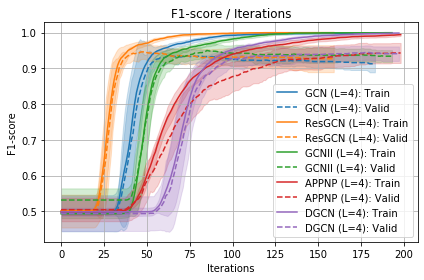

In [16]:
fig, axs = plt.subplots()

for algorithm in ['GCN', 'ResGCN', 'GCNII', 'APPNP', 'DGCN']:
    color = next(axs._get_lines.prop_cycler)['color']
    
    all_epoch_results = algorithm_result[algorithm]
    all_epoch_results_mean, all_epoch_results_std = get_mean_std_epoch_result(all_epoch_results)
    print(all_epoch_results_mean.shape, all_epoch_results_std.shape)
    
    best_iter = np.argmax(all_epoch_results_mean[3])
    test_result = all_epoch_results_mean[4][best_iter]
    stop_iter = np.argmax(all_epoch_results_mean[2])

    y_vals = all_epoch_results_mean[2][:stop_iter]
    y_stds = all_epoch_results_std[2][:stop_iter]
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s (L=%d): Train'%(algorithm, n_layers), color=color, linestyle='-')
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.2, color=color)

    y_vals = all_epoch_results_mean[3][:stop_iter]
    y_stds = all_epoch_results_std[3][:stop_iter]
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s (L=%d): Valid'%(algorithm, n_layers), color=color, linestyle='--')
    # axs.plot(x_vals, y_vals, label='%s (L=%d): Valid (Test F1=%.3f)'%(algorithm, n_layers, test_result), color=color, linestyle='--')
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.2, color=color)
    
    print(algorithm, all_epoch_results_mean[4][best_iter])

plt.title('F1-score / Iterations')
axs.set_ylabel('F1-score')
axs.set_xlabel('Iterations')
axs.grid(True)
fig.tight_layout()
plt.legend()
plt.savefig('f1_score_synthetic.pdf')
# plt.close()

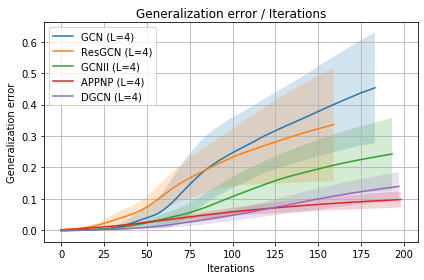

In [17]:
fig, axs = plt.subplots()

for algorithm in ['GCN', 'ResGCN', 'GCNII', 'APPNP', 'DGCN']:
    
    all_epoch_results = algorithm_result[algorithm]
    all_epoch_results_mean, all_epoch_results_std = get_mean_std_epoch_result(all_epoch_results)

    best_iter = np.argmax(all_epoch_results_mean[3])
    test_result = all_epoch_results_mean[4][best_iter]
    stop_iter = np.argmax(all_epoch_results_mean[2])
    
    y_vals = all_epoch_results_mean[5][:stop_iter]
    y_stds = all_epoch_results_std[5][:stop_iter]
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s (L=%d)'%(algorithm, n_layers))
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.2)


plt.title('Generalization error / Iterations')
axs.set_ylabel('Generalization error')
axs.set_xlabel('Iterations')
axs.grid(True)
fig.tight_layout()
plt.legend()
plt.savefig('generalization_error_synthetic.pdf')
# plt.close()